In [16]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
os.chdir("/kaggle/input/eegdata")

/kaggle/input/eegdata/y_test.npy
/kaggle/input/eegdata/main.py
/kaggle/input/eegdata/y_train_valid.npy
/kaggle/input/eegdata/person_train_valid.npy
/kaggle/input/eegdata/EEG_pl.py
/kaggle/input/eegdata/X_test.npy
/kaggle/input/eegdata/dataset.py
/kaggle/input/eegdata/EEG_loading.ipynb
/kaggle/input/eegdata/person_test.npy
/kaggle/input/eegdata/X_train_valid.npy
/kaggle/input/eegdata/classifier.py


In [17]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape, CuDNNGRU
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras import regularizers
from keras.callbacks import EarlyStopping

In [18]:
## Loading the numpy arrays corresponding to the EEG dataset

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Printing the shapes of the numpy arrays

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [19]:
## Adjusting the labels to {0,1,2,3}

# Cue onset left is 769 - 0
# Cue onset right is 770 - 1
# Cue onset foot is 771 - 2
# Cue onset tongue is 772 - 3

y_train_valid -= 769
y_test -= 769

In [20]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y

X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)

Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)


In [21]:
## Creating the training and validation sets

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(8460, 1500, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of training labels after categorical conversion: (6960, 4)
Shape of validation labels after categorical conversion: (1500, 4)
Shape of test labels after categorical conversion: (1772, 4)
Shape of training set after adding width info: (6960, 22, 250, 1)
Shape of validation set after adding width info: (1500, 22, 250, 1)
Shape of test set after adding width info: (1772, 22, 250, 1)
Shape of training set after dimension reshaping: (6960, 250, 1, 22)
Shape of validation set after dimension reshaping: (1500, 250, 1, 22)
Shape of test set after dimension reshaping: (1772, 250, 1, 22)


In [26]:
gru_model = Sequential()

gru_model.add(Flatten(input_shape=(250,1,22)))
gru_model.add(Dense((100))) # FC layer with 100 units
gru_model.add(Reshape((100,1))) # Reshape my output of FC layer so that it's compatible
gru_model.add(CuDNNGRU(256, input_shape=(100,1), return_sequences=False))
gru_model.add(Dropout(0.5))

gru_model.add(Dense((50))) # FC layer with 100 units
gru_model.add(Reshape((50,1))) # Reshape my output of FC layer so that it's compatible
gru_model.add(CuDNNGRU(128, input_shape=(50,1), return_sequences=False))
gru_model.add(Dropout(0.5))


# Output layer with Softmax activation 
gru_model.add(Dense(4, activation='softmax', kernel_regularizer=regularizers.l2(0.01))) # Output FC layer with softmax activation


# Printing the model summary
gru_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 5500)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               550100    
_________________________________________________________________
reshape_3 (Reshape)          (None, 100, 1)            0         
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 256)               198912    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                12850     
_________________________________________________________________
reshape_4 (Reshape)          (None, 50, 1)            

In [28]:
from tensorflow.keras.optimizers import Adam

#won't get validation accuracy ~0.95 when training in 200 epochs with lr=1e-4
learning_rate = 1e-3
epochs = 200
optimizer = Adam(learning_rate=learning_rate)

In [29]:
# Compiling the model
gru_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_accuracy', patience=25)]

# Training and validating the model
gru_results = gru_model.fit(x_train,
             y_train,
             batch_size=32,
             epochs=epochs,
             validation_data=(x_valid, y_valid), 
             callbacks=callbacks,                                             
             verbose=True)

2022-03-13 03:04:41.141997: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-03-13 03:04:43.758810: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


218/218 [==============================] - 6s 14ms/step - loss: 1.3913 - accuracy: 0.3039 - val_loss: 1.3222 - val_accuracy: 0.3660
Epoch 2/200
218/218 [==============================] - 2s 11ms/step - loss: 1.2236 - accuracy: 0.4138 - val_loss: 1.1765 - val_accuracy: 0.4567
Epoch 3/200
218/218 [==============================] - 3s 12ms/step - loss: 1.0861 - accuracy: 0.4940 - val_loss: 1.1106 - val_accuracy: 0.5047
Epoch 4/200
218/218 [==============================] - 2s 11ms/step - loss: 0.9692 - accuracy: 0.5598 - val_loss: 1.0786 - val_accuracy: 0.4920
Epoch 5/200
218/218 [==============================] - 2s 11ms/step - loss: 0.8553 - accuracy: 0.6102 - val_loss: 0.8741 - val_accuracy: 0.5947
Epoch 6/200
218/218 [==============================] - 2s 11ms/step - loss: 0.7562 - accuracy: 0.6428 - val_loss: 0.8517 - val_accuracy: 0.6027
Epoch 7/200
218/218 [==============================] - 3s 13ms/step - loss: 0.7067 - accuracy: 0.6540 - val_loss: 0.7920 - val_accuracy: 0.6353
Epoc

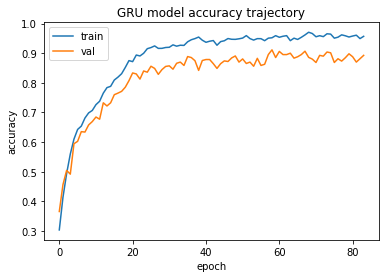

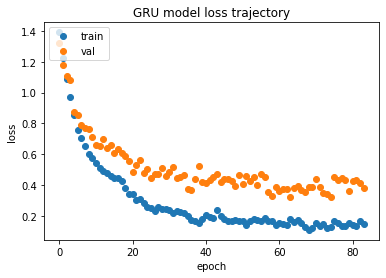

In [31]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(gru_results.history['accuracy'])
plt.plot(gru_results.history['val_accuracy'])
plt.title('GRU model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(gru_results.history['loss'],'o')
plt.plot(gru_results.history['val_loss'],'o')
plt.title('GRU model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [33]:
## Testing the hybrid CNN-LSTM model

gru_score = gru_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the GRU model:',gru_score[1])

Test accuracy of the GRU model: 0.3504514694213867


In [34]:
from sklearn import metrics
from sklearn.metrics import classification_report

y_pred_test = gru_model.predict(x_test)


# classification_report
for i,x in enumerate(['left','right','foot','tongue']):
    print(x)
    y_pred = np.where(y_pred_test[:,i]>0.5,1,0)
    
    print(classification_report(y_test[:,i], y_pred))

left
              precision    recall  f1-score   support

         0.0       0.78      0.83      0.80      1328
         1.0       0.37      0.30      0.33       444

    accuracy                           0.70      1772
   macro avg       0.57      0.56      0.57      1772
weighted avg       0.68      0.70      0.68      1772

right
              precision    recall  f1-score   support

         0.0       0.72      0.64      0.68      1264
         1.0       0.30      0.39      0.34       508

    accuracy                           0.57      1772
   macro avg       0.51      0.51      0.51      1772
weighted avg       0.60      0.57      0.58      1772

foot
              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81      1388
         1.0       0.31      0.31      0.31       384

    accuracy                           0.70      1772
   macro avg       0.56      0.56      0.56      1772
weighted avg       0.70      0.70      0.70      1772

ton

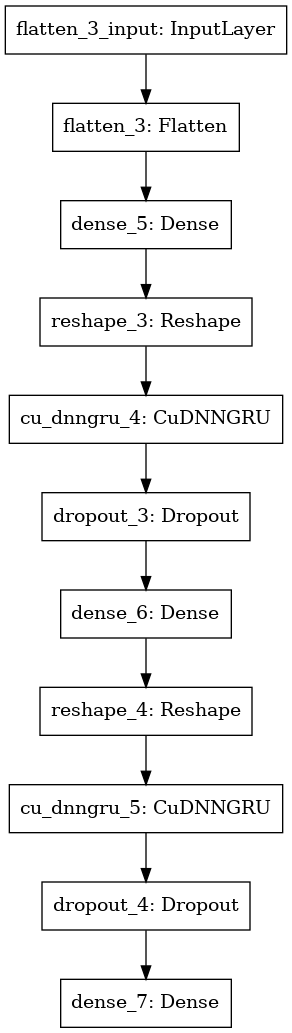

In [35]:
import tensorflow as tf

os.chdir("/kaggle/working")
tf.keras.utils.plot_model(gru_model)